In [1]:
# # AAI-540: MLOps Group Project (Final Version)
# ## Cloud DevOps Deployment Effectiveness Prediction

In [2]:
# SETUP AND CONFIG
import pandas as pd
import sagemaker
import boto3
import time
from datetime import datetime
import re
from sagemaker.feature_store.feature_group import FeatureGroup
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

print(f"✅ Setup complete. Using bucket '{bucket}'")

✅ Setup complete. Using bucket 'sagemaker-us-east-1-878962000052'


In [4]:
# Set up S3 File Paths
raw_s3_path = f's3://{bucket}/raw_data/DevOps AWS Azure Effectiveness Deployment.csv'
df = pd.read_csv(raw_s3_path)

print("✅ Raw data loaded successfully from S3 Data Lake.")
print(df.head())

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:298: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


✅ Raw data loaded successfully from S3 Data Lake.
   Organization Name  DevOps Efficiency Score  Deployment Time (hours)  \
0          97.280867                27.005785                82.330643   
1          50.655977                71.733429                89.419236   
2          85.690327                49.673990                16.089223   
3          86.962197                47.681079                74.915795   
4          50.486453                84.282712                76.790907   

   Resource Usage (GB)  AWS Scalability Score  Azure Reliability Score  \
0            31.176731              99.669022                 9.217916   
1            78.708647              86.045506                73.141908   
2            92.874775              40.071560                19.208071   
3            86.126322              36.647329                49.482157   
4            17.610578               2.469869                15.461407   

   Cost Efficiency ($)  User Feedback Score  Platform Compar

Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Organization Name                50000 non-null  float64
 1   DevOps Efficiency Score          50000 non-null  float64
 2   Deployment Time (hours)          50000 non-null  float64
 3   Resource Usage (GB)              50000 non-null  float64
 4   AWS Scalability Score            50000 non-null  float64
 5   Azure Reliability Score          50000 non-null  float64
 6   Cost Efficiency ($)              50000 non-null  float64
 7   User Feedback Score              50000 non-null  float64
 8   Platform Comparison Index        50000 non-null  float64
 9   Cloud Integration Effectiveness  50000 non-null  float64
 10  Data Security Level              50000 non-null  float64
 11  Ethical Compliance               50000 non-null  float64
 12  Perfo

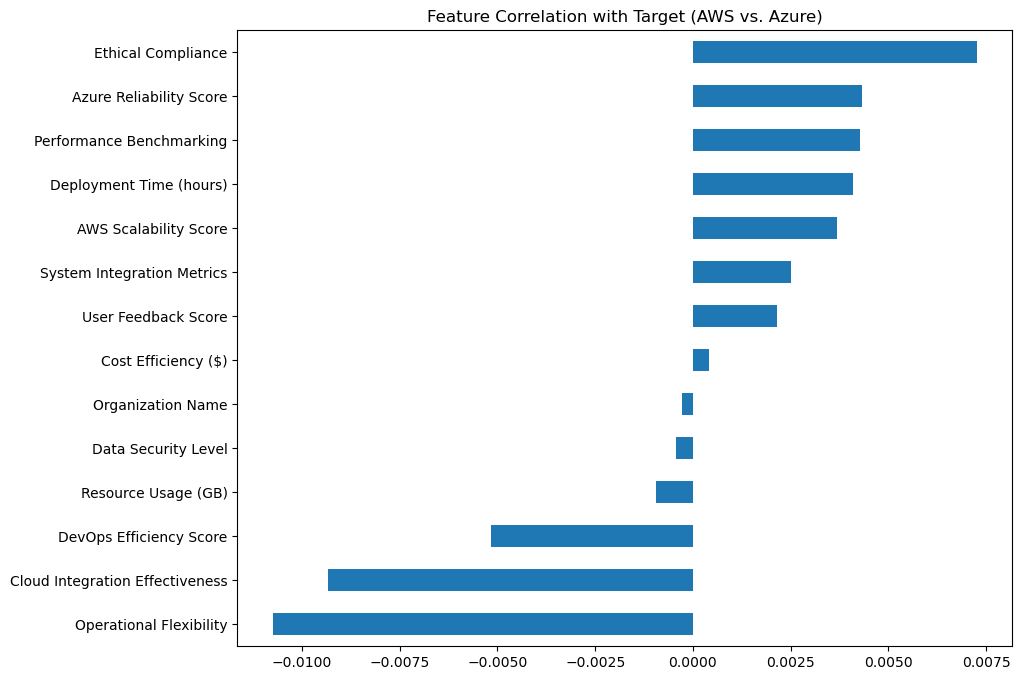

In [5]:
# Load Data & Process Data
print("Dataset Info")
df.info()

print("\nDescriptive Statistics")
print(df.describe())

print("\nCorrelation Analysis ")
# Creates a temporary target variable for correlation analysis
temp_target = (df['Platform Comparison Index'] > 50).astype(int)
correlations = df.corrwith(temp_target)

plt.figure(figsize=(10, 8))
correlations.drop('Platform Comparison Index').sort_values().plot(kind='barh')
plt.title('Feature Correlation with Target (AWS vs. Azure)')
plt.show()

In [6]:
# Feature Engineering
df['Target'] = (df['Platform Comparison Index'] > 50).astype(int)
df_cleaned = df.drop(columns=['Platform Comparison Index', 'Organization Name'])

In [7]:
# Cleans column names for SageMaker Feature Store compatibility

def clean_col_names(df):
    cols = df.columns
    new_cols = []
    for col in cols:
        # First, replaces spaces with underscores
        new_col = col.replace(' ', '_')
        # Second, removes all non-alphanumeric characters except underscores
        new_col = re.sub(r'[^A-Za-z0-9_]+', '', new_col)
        # Third, removes any leading/trailing underscores and convert to lowercase
        new_col = new_col.strip('_').lower()
        new_cols.append(new_col)
    df.columns = new_cols
    return df

df_cleaned = clean_col_names(df_cleaned)
print("✅ Cleaned column names:")
print(df_cleaned.columns)

✅ Cleaned column names:
Index(['devops_efficiency_score', 'deployment_time_hours', 'resource_usage_gb',
       'aws_scalability_score', 'azure_reliability_score', 'cost_efficiency',
       'user_feedback_score', 'cloud_integration_effectiveness',
       'data_security_level', 'ethical_compliance', 'performance_benchmarking',
       'system_integration_metrics', 'operational_flexibility', 'target'],
      dtype='object')


In [8]:
# SageMaker Feature Store Setup
feature_group_name = 'devops-effectiveness-features-v1'
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=sagemaker_session)

In [9]:
# Function to clean column names for Feature Store.
try:
    print(f"Checking for existing Feature Group '{feature_group_name}'...")
    feature_group.describe()
    print("Found existing Feature Group. Deleting it now...")
    feature_group.delete()
    print("Waiting for deletion to complete...")
    waiter = sagemaker_session.sagemaker_client.get_waiter('feature_group_deleted')
    waiter.wait(FeatureGroupName=feature_group_name)
    
    #
    print("Pausing for 5 seconds to allow AWS to fully process the deletion...")
    time.sleep(5) 
    
    print("✅ Old Feature Group successfully deleted.")
except Exception as e:
    print("✅ No old Feature Group found. Ready to create a new one.")

# Add ID and Timestamp Columns
if 'record_id' not in df_cleaned.columns:
    df_cleaned.insert(0, 'record_id', range(0, len(df_cleaned)))
if 'event_time' not in df_cleaned.columns:
    event_time_str = datetime.now().strftime('%Y-%m-%dT%H:%M:%SZ')
    df_cleaned.insert(1, 'event_time', event_time_str)

feature_group.load_feature_definitions(data_frame=df_cleaned)
feature_group.create(
    s3_uri=f"s3://{bucket}/feature-store",
    record_identifier_name="record_id",
    event_time_feature_name="event_time",
    role_arn=role,
    enable_online_store=False 
)

# Wait for the feature group to be created
print("Waiting for Feature Group to become ACTIVE...")
while True:
    status = feature_group.describe().get("FeatureGroupStatus")
    if status == "Created":
        print(f"✅ Feature Group '{feature_group_name}' is now ACTIVE.")
        break
    if status == "CreateFailed":
        error_message = feature_group.describe().get("FailureReason")
        # If creation fails, stop the process and show the error
        raise Exception(f"Feature Group creation failed: {error_message}")
    print(f"Current status: {status}. Waiting 5 seconds...")
    time.sleep(5)

print("\nIngesting data... (This may take several minutes, please be patient)")
feature_group.ingest(data_frame=df_cleaned, max_workers=3, wait=True)
print("\n✅ Feature data successfully stored in SageMaker Feature Store.")

Checking for existing Feature Group 'devops-effectiveness-features-v1'...
Found existing Feature Group. Deleting it now...
Waiting for deletion to complete...
✅ No old Feature Group found. Ready to create a new one.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:27                                                                                   │
│                                                                                                  │
│   24 │   df_cleaned.insert(1, 'event_time', event_time_str)                                      │
│   25                                                                                             │
│   26 feature_group.load_feature_definitions(data_frame=df_cleaned)                               │
│ ❱ 27 feature_group.create(                                                                       │
│   28 │   s3_uri=f"s3://{bucket}/feature-store",                                                  │
│   29 │   record_identifier_name="record_id",                                                     │
│   30 │   event_time_feature_name="event_time",                                                   │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/feature_store/featu │
│ re_group.py:789 in create                                                                        │
│                                                                                                  │
│    786 │   │   │   │   {"offline_store_config": offline_store_config.to_dict()}                  │
│    787 │   │   │   )                                                                             │
│    788 │   │                                                                                     │
│ ❱  789 │   │   return self.sagemaker_session.create_feature_group(**create_feature_store_args)   │
│    790 │                                                                                         │
│    791 │   def delete(self):                                                                     │
│    792 │   │   """Delete a FeatureGroup."""                                                      │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py:6610 in  │
│ create_feature_group                                                                             │
│                                                                                                  │
│   6607 │   │   │   Description=description,                                                      │
│   6608 │   │   │   Tags=tags,                                                                    │
│   6609 │   │   )                                                                                 │
│ ❱ 6610 │   │   return self.sagemaker_client.create_feature_group(**kwargs)                       │
│   6611 │                                                                                         │
│   6612 │   def describe_feature_group(                                                           │
│   6613 │   │   self,                                                                             │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/client.py:602 in     │
│ _api_call                                                                                        │
│                                                                                                  │
│    599 │   │   │   │   │   f"{py_operation_name}() only accepts keyword arguments."              │
│    600 │   │   │   │   )                                                                         │
│    601 │   │   │   # The "self" in this scope is referring to the BaseClient.                    │
│ ❱  602 │   │   │   return self._make_api_call(operation_nam

In [ ]:
df_model_ready = df_cleaned.drop(columns=['record_id', 'event_time'])

# First split: 60% for modeling, 40% for "production" holdout
df_modeling, df_production = train_test_split(
    df_model_ready, test_size=0.40, random_state=42, stratify=df_model_ready['target']
)

# Second split: From the 60% (df_modeling), take 40% (of the original) for training.
df_train, df_temp = train_test_split(
    df_modeling, train_size=(0.4/0.6), random_state=42, stratify=df_modeling['target']
)

# Third split: The rest (df_temp) is now 20% of the original. Split it in half.
df_validation, df_test = train_test_split(
    df_temp, test_size=0.50, random_state=42, stratify=df_temp['target']
)

print(f"Total records: {len(df_model_ready)}")
print("---")
print(f"Training set size:   {len(df_train)} (~40%)")
print(f"Validation set size: {len(df_validation)} (~10%)")
print(f"Test set size:       {len(df_test)} (~10%)")
print(f"Production set size: {len(df_production)} (~40%)")
print("\n✅ Data splitting complete.")

In [ ]:
# Import necessary libraries for modeling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

# Prepare data for scikit-learn
# Separates features (X) from the target (y)
X_train = df_train.drop('target', axis=1)
y_train = df_train['target']

X_validation = df_validation.drop('target', axis=1)
y_validation = df_validation['target']

# Train the Logistic Regression model
print("Training the Logistic Regression model...")
model = LogisticRegression(random_state=42, max_iter=1000) # Added max_iter for convergence
model.fit(X_train, y_train)
print("✅ Model training complete.")

# Evaluate the model on the validation set
print("\nEvaluating model performance...")
y_pred = model.predict(X_validation)

accuracy = accuracy_score(y_validation, y_pred)
print(f"\nValidation Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_validation, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_validation, y_pred))

# Save the trained model artifact
model_file_name = 'model.joblib'
joblib.dump(model, model_file_name)
print(f"\n✅ Model saved locally as '{model_file_name}'")

# Upload the model artifact to S3
model_s3_path = f"s3://{bucket}/models/{model_file_name}"
sagemaker_session.upload_data(path=model_file_name, key_prefix="models")
print(f"✅ Model artifact uploaded to S3: {model_s3_path}")